In [1]:
import numpy as np
import pandas as pd

import emcee
import corner

import os
CWD = "/".join(os.getcwd().split("/")[:-2])

import matplotlib.pyplot as plt
%matplotlib inline

from funcs.model import full_model_2flares2ars, aflare, calculate_angular_radius

import astropy.units as u
from astropy.constants import R_sun

import matplotlib 
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 

font = {'family' : 'courier',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

/work1/eilin/Flares_in_Clusters_2/RESULTS_Github/flares-in-clusters-with-k2-ii/flaresinclustersii/lib/python3.7/site-packages/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [8]:
ID = 237880881#212035340 #100004076#
tstamp = '11_02_2020_11_16'

In [9]:
props = pd.read_csv(f"{CWD}/data/summary/everything.csv")
target = props[props.ID == ID].iloc[0]
R = target.Rstar *R_sun

In [10]:
inits = pd.read_csv(f"{CWD}/data/summary/inits.csv")
inits = inits[(inits.ID == str(ID)+"b")&(inits.tstamp==tstamp)].iloc[0]
qlum = inits.qlum_erg_s *u.erg/u.s
Fth = inits.Fth * u.erg/u.cm**2/u.s
median = inits.median

In [11]:
lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{ID}.csv")

In [12]:
target

ID                           237880881
QCS                                  1
typ                                slc
cadence_min                          2
mission                           tess
prefix                             TIC
origin                         generic
h_mission                         TESS
SpT                                 M5
view_start                        1331
view_stop                       1333.5
view_min                           560
view_max                           700
BJDoff                         2457000
tstart                          1331.7
ampl_min                           NaN
ampl_max                           NaN
RA                              19.528
Dec                           -62.9831
J                                11.53
R                                  NaN
Gaia_G                         14.9796
vsini_kms                         14.4
e_vsini_kms                        2.6
Prot_d                         0.35125
sini                     

In [ ]:
# see here https://emcee.readthedocs.io/en/stable/tutorials/monitor/
filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}b_MCMC.h5"
reader = emcee.backends.HDFBackend(filename)

tau = reader.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
# burnin=50000
# thin=15
# ndim=10
samples = reader.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = reader.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = reader.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))
print("flat log prior shape: {0}".format(log_prior_samples.shape))


In [ ]:
from mcmc_analysis_tables import write_meta_mcmc
write_meta_mcmc(CWD, tstamp, target.ID, burnin, steps, walkers, nparam, ndim)

In [9]:

#map phi_a_distr to t0_distr:
for i in [0,1]:
    samples[:, i] = np.interp(samples[:,i],lc.phi,lc.t)

# convert theta_f to degrees
for i in [2,3]:
    samples[:, i] = samples[:, i] / np.pi * 180.

# convert FWHM to days
for i in [6,7]:
    samples[:, i] = samples[:, i]/2/np.pi*target.Prot_d 

# convert i to degrees
samples[:, -2] = samples[:, -2] / np.pi * 180.

# map phi0 to phi_peak longitude, still call it phi0
samples[:, -1] = (samples[:, 0]%(2.*np.pi) - samples[:, -1]) / np.pi * 180. # 0 would be facing the observer





# Plots
### Plot the full chain

findfont: Font family ['courier'] not found. Falling back to DejaVu Sans.
findfont: Font family ['courier'] not found. Falling back to DejaVu Sans.


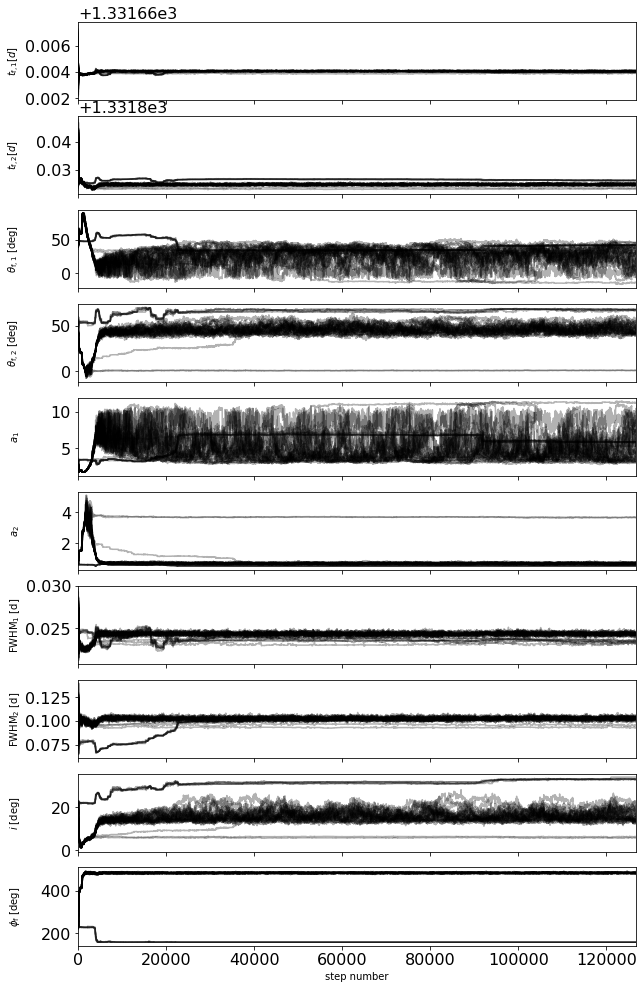

In [10]:
fig, axes = plt.subplots(10, figsize=(10, 17), sharex=True)

multi_samples = reader.get_chain()

walkers = multi_samples.shape[1]
steps = multi_samples.shape[0]
nparam = multi_samples.shape[2]

# -----------------------------------------------------------------------
#map phi_a_distr to t0_distr:
for i in [0,1]:
    multi_samples[:, :,i] = np.interp(multi_samples[:,:,i],lc.phi,lc.t)

# convert theta_f to degrees
for i in [2,3]:
    multi_samples[:, :,i] = multi_samples[:,:, i] / np.pi * 180.

# convert FWHM to days
for i in [6,7]:
    multi_samples[:,:, i] = multi_samples[:,:, i]/2/np.pi*target.Prot_d 

# convert i to degrees
multi_samples[:,:, -2] = multi_samples[:,:, -2] / np.pi * 180.

# map phi0 to phi_peak longitude, still call it phi0
multi_samples[:,:, -1] = (multi_samples[:, :,0]%(2.*np.pi) - multi_samples[:,:, -1]) / np.pi * 180. # 0 would be facing the observer
# -----------------------------------------------------------------------
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 

labels = [r'$t_\mathrm{f,1} [d]$', r'$t_\mathrm{f,2} [d]$',
          r'$\theta_\mathrm{f,1}$ [deg]', r'$\theta_\mathrm{f,2}$ [deg]', 
          r'$a_1$', r'$a_2$',
          r'FWHM$_1$ [d]', r'FWHM$_2$ [d]', 
          r'$i$ [deg]',
          r"$\phi_\mathrm{f}$ [deg]"]
for j in range(ndim):
    ax = axes[j]
    ax.plot(multi_samples[:, :, j], "k", alpha=0.3)
    ax.set_xlim(0, len(multi_samples))
    ax.set_ylabel(labels[j])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.savefig(f"{CWD}/analysis/plots/flarefit/{tstamp}_{target.prefix}{target.ID}_chain.png",dpi=300)

### Corner plot

Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours


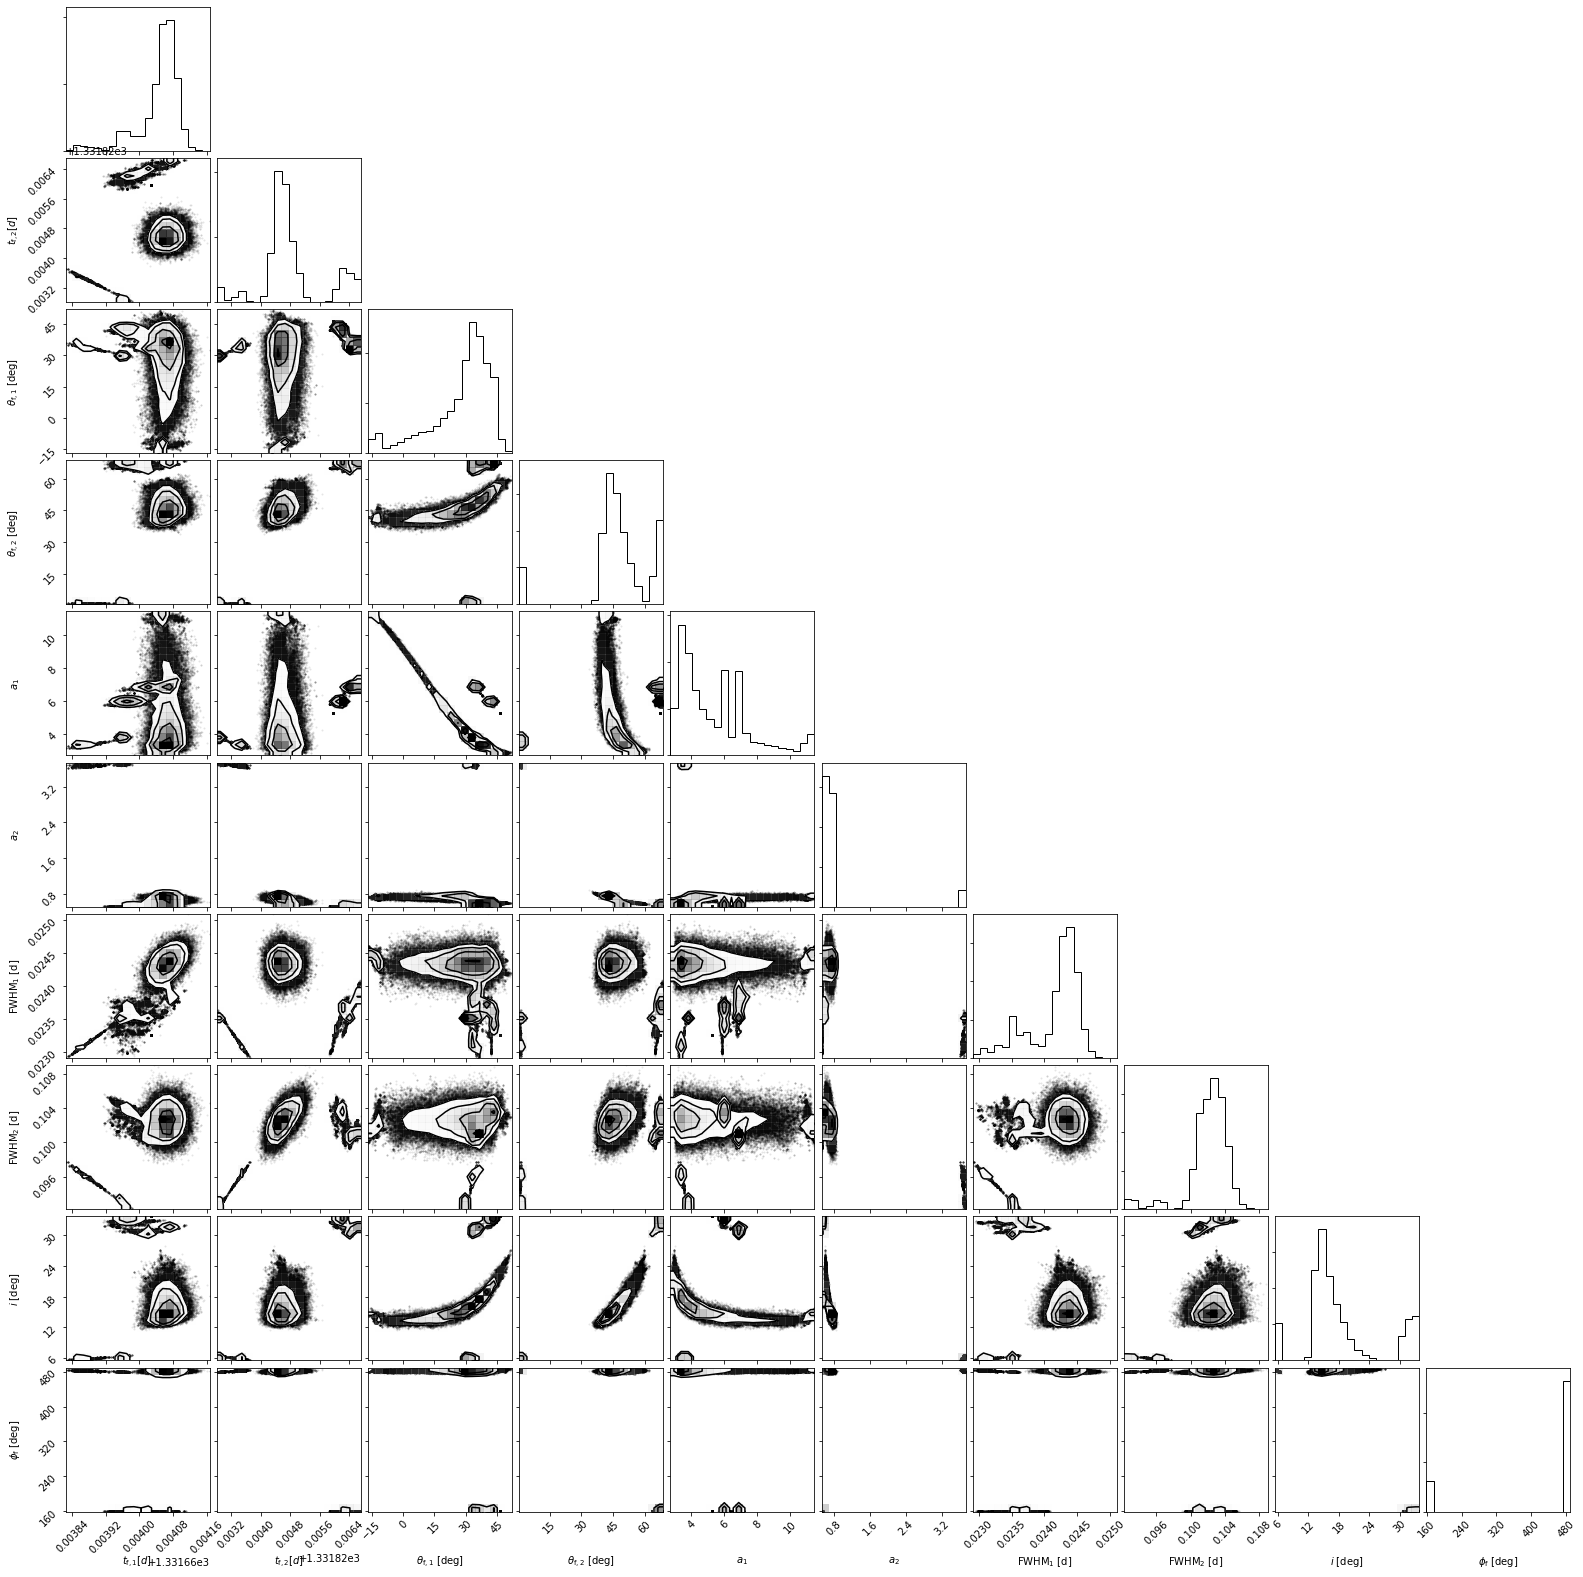

In [11]:

fig = corner.corner(samples, labels=labels)# truths=[phi_a, theta_a, a, fwhm,i_mu, phi0]);
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
plt.savefig(f"{CWD}/analysis/plots/flarefit/{tstamp}_{target.prefix}{target.ID}_corner_disc{burnin}.png",dpi=300)

In [12]:
0.37 / np.pi *180

21.199438419840458

### Retrieve and plot some example fits to the data from the chain

/work1/eilin/MultiperiodFlares/MalachiteMountains/analysis/notebooks/funcs/model.py:497: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(-np.tan(l) * np.tan(np.pi/2-i)) / np.pi


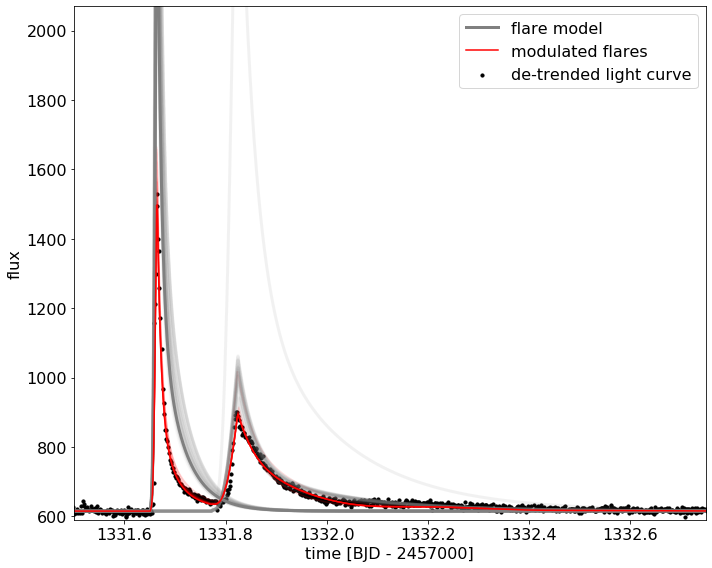

In [13]:
N = 50
phi = lc.phi.values
time = lc.t
flux = lc.flux.values
median = lc.median_[0]
flat_samples = reader.get_chain(discard=burnin, flat=True, thin=thin)
inds = np.random.randint(len(flat_samples), size=N)
plt.figure(figsize=(10,8))

plt.scatter(time, flux, s=10, c="k", label=r"de-trended light curve")
#plt.errorbar(phi, flux, yerr=flux_err, fmt=".k", capsize=0)

for ind in inds:
    sample = flat_samples[ind]
    phi_a1, phi_a2, theta_a1, theta_a2, a1, a2, fwhm1, fwhm2, i, phi0 = sample
    if a1<6:
        plt.plot(time, aflare(phi, phi_a1, fwhm1, a1*median)+ median, c="grey", alpha=0.05, linewidth=3)
        plt.plot(time, aflare(phi, phi_a2, fwhm2, a2*median)+ median, c="grey", alpha=0.05, linewidth=3)
        plt.plot(time, full_model_2flares2ars((phi_a1,phi_a2), (theta_a1,theta_a2), (a1,a2), (fwhm1,fwhm2), i, phi0=phi0,
                   phi=phi, num_pts=50, qlum=qlum,
                   Fth=Fth, R=R, median=median), c="r", alpha=0.05,)
    

plt.plot(time, aflare(phi, phi_a1, fwhm1, a1*median)+ median, c="grey", alpha=1, linewidth=3,label="flare model")
plt.plot(time, full_model_2flares2ars((phi_a1,phi_a2), (theta_a1,theta_a2), (a1,a2), (fwhm1,fwhm2), i, phi0=phi0,
           phi=phi, num_pts=50, qlum=qlum,
           Fth=Fth, R=R, median=median), c="r", alpha=1, label="modulated flares")
#plt.plot(phi, flare+median, c="r",linewidth=1)
plt.legend(fontsize=16)
plt.xlabel(f"time [BJD - {target.BJDoff}]",fontsize=16)
plt.ylabel("flux",fontsize=16);
#plt.yscale("log")
plt.ylim(590,2070)
plt.xlim(1331.5,1332.75)
plt.tight_layout()
plt.savefig(f"{CWD}/analysis/plots/flarefit/{tstamp}_{target.prefix}{target.ID}_flarefit_{N}retrievals.png",dpi=300)

# Results

### What are the most likely angular radii of the active region?

In [14]:
calculate_angular_radius(Fth, 6, qlum, R)

80.98438275235254

In [15]:
rads1=[]
for a in samples[:,4]:
#func = np.vectorize(calculate_angular_radius)#(Fth, flat_samples[:,2], qlum, R, 0, 0, np.pi/2, phi0=0)
    try:
        rads1.append(calculate_angular_radius(Fth, a, qlum, R))
    except ValueError:
        continue
print("finished rad 1")  
rads2=[]
for a in samples[:,5]:
#func = np.vectorize(calculate_angular_radius)#(Fth, flat_samples[:,2], qlum, R, 0, 0, np.pi/2, phi0=0)
    rads2.append(calculate_angular_radius(Fth, a, qlum, R))

finished rad 1


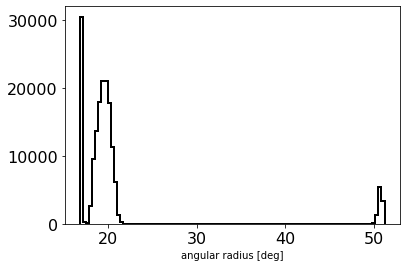

In [16]:
percentiles = [16,50,84]
plt.hist(rads2,bins=100, histtype="step",color="k",linewidth=2);
radius1_p = np.percentile(rads1, percentiles, axis=0)
plt.xlabel("angular radius [deg]")
plt.savefig(f"{CWD}/analysis/plots/flarefit/{tstamp}_{target.prefix}{target.ID}_active_region_radii_ar2.png",dpi=300)

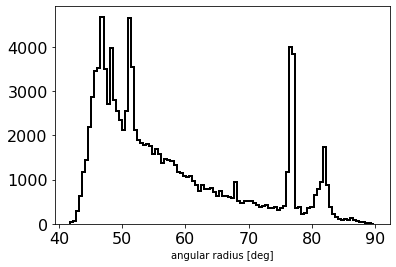

In [17]:
plt.hist(rads1,bins=100, histtype="step",color="k",linewidth=2);
radius2_p = np.percentile(rads2, percentiles, axis=0)
plt.xlabel("angular radius [deg]")
plt.savefig(f"{CWD}/analysis/plots/flarefit/{tstamp}_{target.prefix}{target.ID}_active_region_radii_ar1.png",dpi=300)

### Equivalent duration distribution

In [18]:
def calculate_ED(t, t0, dur, ampl):
    return np.sum(np.diff(t) * aflare(t, t0, dur, ampl)[:-1]) * 60.0 * 60.0 * 24.0

In [19]:


t0_distr = samples[:,0]
a_distr = samples[:,4]
fwhm_distr = samples[:,6]

l = len(t0_distr)
print(np.mean(t0_distr),np.mean(fwhm_distr),np.median(a_distr))
ED_distr1 = []
for i in range(l):
    ED_distr1.append(calculate_ED(lc.t.values, t0_distr[i], fwhm_distr[i], a_distr[i] ))

print("finished ED distr 1") 

t0_distr = samples[:,1]
a_distr = samples[:,5]
fwhm_distr = samples[:,7]
print(np.mean(t0_distr),np.mean(fwhm_distr),np.median(a_distr))
ED_distr2 = []
for i in range(l):
    ED_distr2.append(calculate_ED(lc.t.values, t0_distr[i], fwhm_distr[i], a_distr[i] ))

1331.6640454681421 0.024144001487996718 4.802491450856641
finished ED distr 1
1331.8248438742178 0.10204445992159793 0.6767503996199202


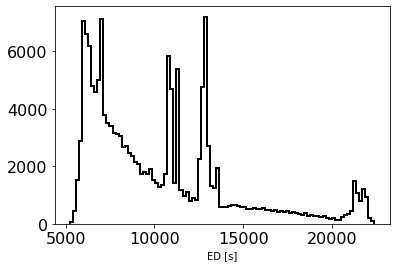

In [20]:
percentiles = [16,50,84]
ED_distr1 = np.array(ED_distr1)
plt.hist(ED_distr1,bins=100, histtype="step",color="k",linewidth=2);
ED_distr1_p = np.percentile(ED_distr1, percentiles, axis=0)
plt.xlabel("ED [s]")
plt.savefig(f"{CWD}/analysis/plots/flarefit/{tstamp}_{target.prefix}{target.ID}_flare1_ED.png",dpi=300)

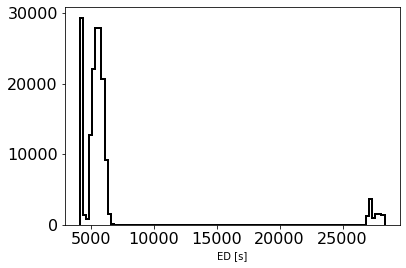

In [21]:
ED_distr2 = np.array(ED_distr2)
plt.hist(ED_distr2,bins=100, histtype="step",color="k",linewidth=2);
ED_distr2_p = np.percentile(ED_distr2, percentiles, axis=0)
plt.xlabel("ED [s]")
plt.savefig(f"{CWD}/analysis/plots/flarefit/{tstamp}_{target.prefix}{target.ID}_flare2_ED.png",dpi=300)

### Percentiles of fitted parameters

In [22]:
percentiles = [16,50,84]
#phi_a1, phi_a2, theta_a, a1, a2, fwhm1, fwhm2, i, phi0 
t01_p, t02_p, theta_a_p1, theta_a_p2, a1_p, a2_p, fwhm1_p, fwhm2_p, i_p, phi0_p = map(lambda v: (v[0], v[1], v[2]),
                                                   zip(*np.percentile(samples, percentiles,
                                                       axis=0)))


# Write percentiles to file
with open(f"{CWD}/analysis/results/mcmc/mcmcoutput.csv","a") as f:
    #Add more lines here
    
    # First flare
    out = f"{tstamp},{target.ID},a,{burnin},{steps},{walkers},{nparam},k,dotted"
    firstout = f"date,ID,suffix,burnin,steps,walkers,nparam,color,linestyle"
    for i in ['t01_p', 'theta_a_p1', 'a1_p', 'fwhm1_p', 'i_p', 'phi0_p', 'radius1_p', 'ED_distr1_p', 'Eflare1_p']:
        firstout += f"{i}{percentiles[0]},{i}{percentiles[1]},{i}{percentiles[2]},"
    for i in [t01_p, theta_a_p1, a1_p, fwhm1_p, i_p, phi0_p, radius1_p, ED_distr1_p, (ED_distr1_p*qlum).value ]:
        out += f"{i[0]},{i[1]},{i[2]},"
    out += "\n"
    firstout += "\n"
    f.write(firstout)
    f.write(out)
    
    # Second flare
    out = f"{tstamp},{target.ID},b,{burnin},{steps},{walkers},{nparam},k,dashdot"
    firstout = f"date,ID,suffix,burnin,steps,walkers,nparam,color,linestyle"
    for i in ['t02_p', 'theta_a_p2', 'a2_p', 'fwhm2_p', 'i_p', 'phi0_p', 'radius2_p', 'ED_distr2_p', 'Eflare2_p']:
        firstout += f"{i}{percentiles[0]},{i}{percentiles[1]},{i}{percentiles[2]},"
    for i in [t02_p, theta_a_p2, a2_p, fwhm2_p, i_p, phi0_p, radius2_p, ED_distr2_p, (ED_distr2_p*qlum).value ]:
        out += f"{i[0]},{i[1]},{i[2]},"
    out += "\n"
    firstout += "\n"
    f.write(firstout)
    f.write(out)